# Feature Contribution Analysis
In this notebook, I will examine the feature contributions calculated by LRP. There are two kinds of different contribution scores to every gene:
* A feature contribution that tells us how important each of the features were for the classification of that gene as being a cancer gene
* A neighbor contribution that tells us which of its interacting partners in the PPI were most important for the classification of that gene

Here, we will only look at the feature contributions. We will apply spectral biclustering of the top 1000 EMOGI predictions and see different classes of cancer genes.
The number of clusters is calculated using the eigengap analysis. Furthermore, we check that doing the analysis with all genes yields mainly two clusters for highly and lowly predicted genes, giving not much relevant new information. Also, clustering the input is not as powerful to find distinct classes of cancer genes.

In [1]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess
import scipy

# clustering & embedding
from sklearn.cluster import SpectralBiclustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap
import sklearn
from sklearn import preprocessing

# Linear Algebra for eigengap analysis
from scipy.spatial.distance import pdist, squareform
import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA
from sklearn import metrics

# other modules of mine
sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

# GO enrichment analysis
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_human
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
sys.path.append(os.path.abspath('../pancancer'))
import preprocessing_utils as ut

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

## Relevant Paths
* `achilles_data_path`: Path to the achilles CRSIPR gene effect csv file that can be downloaded [here](https://depmap.org/portal/download/)
* `model_dir`: Path to the training directory where both, the model and the LRP contributions are stored.

In [2]:
achilles_data_path = '../data/pancancer/Achilles/Achilles_gene_effect.csv'
model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
ncg_cancer_genes_path = '../data/pancancer/NCG/cancergenes_list.txt'
oncokb_path = '../data/pancancer/oncoKB/cancerGeneList.txt'
cgc_path = '../data/pancancer/cosmic/cancer_gene_census.csv'

In [3]:
def get_cancer_genes():
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open(ncg_cancer_genes_path, 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])

    oncokb_genes = pd.read_csv(oncokb_path, sep='\t')
    return oncokb_genes, known_cancer_genes, candidate_cancer_genes


def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg)
    plt.fill_between(range(data.shape[0]), rolling_avg)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def get_pathway_enrichment(genes, universe, cluster_idx, out_dir, clean_up=True):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    universe.set_index('ID').to_csv(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)), sep='\t')

    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                              genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    
    if clean_up:
        os.remove(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)))
        os.remove(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)))

    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    if rep_std is None:
        ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)
    else:
        ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels, yerr=rep_std.values)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', labelsize=16)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=18)
    ax.set_ylabel('Feature\nContribution', fontsize=18)
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = x.max()
    vmin = x.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0:.0E}  {1}  {2}  {3}'.format(pathways.iloc[i]['Pvalue'],
                                                              pathways.iloc[i]['Count'],
                                                              pathways.iloc[i]['Size'],
                                                              pathways.iloc[i]['Term']
                                                             ), fontsize=12
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

## Load the LRP Results

In [4]:
args, _ = gcnIO.load_hyper_params(model_dir)
hdf_path = os.path.join(model_dir, args['data'])
with h5py.File(hdf_path, 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
    features = f['features'][:]
    features_raw = f['features_raw'][:]
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

In [5]:
pred = postprocessing.load_predictions(model_dir)

In [6]:
(feat_contrib_df == 0).all(axis=1).sum()

0

## Clustering of Contribution for Top 1000 Genes

In [7]:
# select only top 1000 predictions
high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred.head(1000).Name)]
#high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred[pred.Prob_pos > 0.95].Name)]
high_feat_contrib = high_feat_contrib[high_feat_contrib.sum(axis=1).between(-1, 1)]
print ("Selected {} Genes for Spectral Biclustering".format(high_feat_contrib.shape[0]))

# remove negative contributions
high_feat_contrib_capped = high_feat_contrib.copy()
high_feat_contrib_capped[high_feat_contrib_capped < 0] = 0

high_feat_contrib_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(high_feat_contrib_capped),
                                        index=high_feat_contrib.index, columns=high_feat_contrib.columns)

Selected 999 Genes for Spectral Biclustering


### Find Appropriate Number of Clusters using Eigengap Analysis

In [8]:
# the code here is copy pasted from https://github.com/ciortanmadalina/high_noise_clustering/blob/master/spectral_clustering.ipynb
# the corresponding article is here: https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe

def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates))
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix
    
    
def eigenDecomposition(A, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#   eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
            
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors


affinity_matrix = getAffinityMatrix(high_feat_contrib_normed, k = 4)
k, evals_row, e_vecs_row = eigenDecomposition(affinity_matrix)
print(f'Optimal number of row clusters {k}')

aff_mat_cols = getAffinityMatrix(high_feat_contrib_normed.T, k = 7)
k_col, evals_col, evecs_col  = eigenDecomposition(aff_mat_cols)
print(f'Optimal number of col clusters {k_col}')

Optimal number of row clusters [ 9 17 23 30 36]
Optimal number of col clusters [ 1  5  3  2 11]


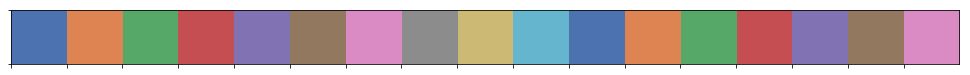

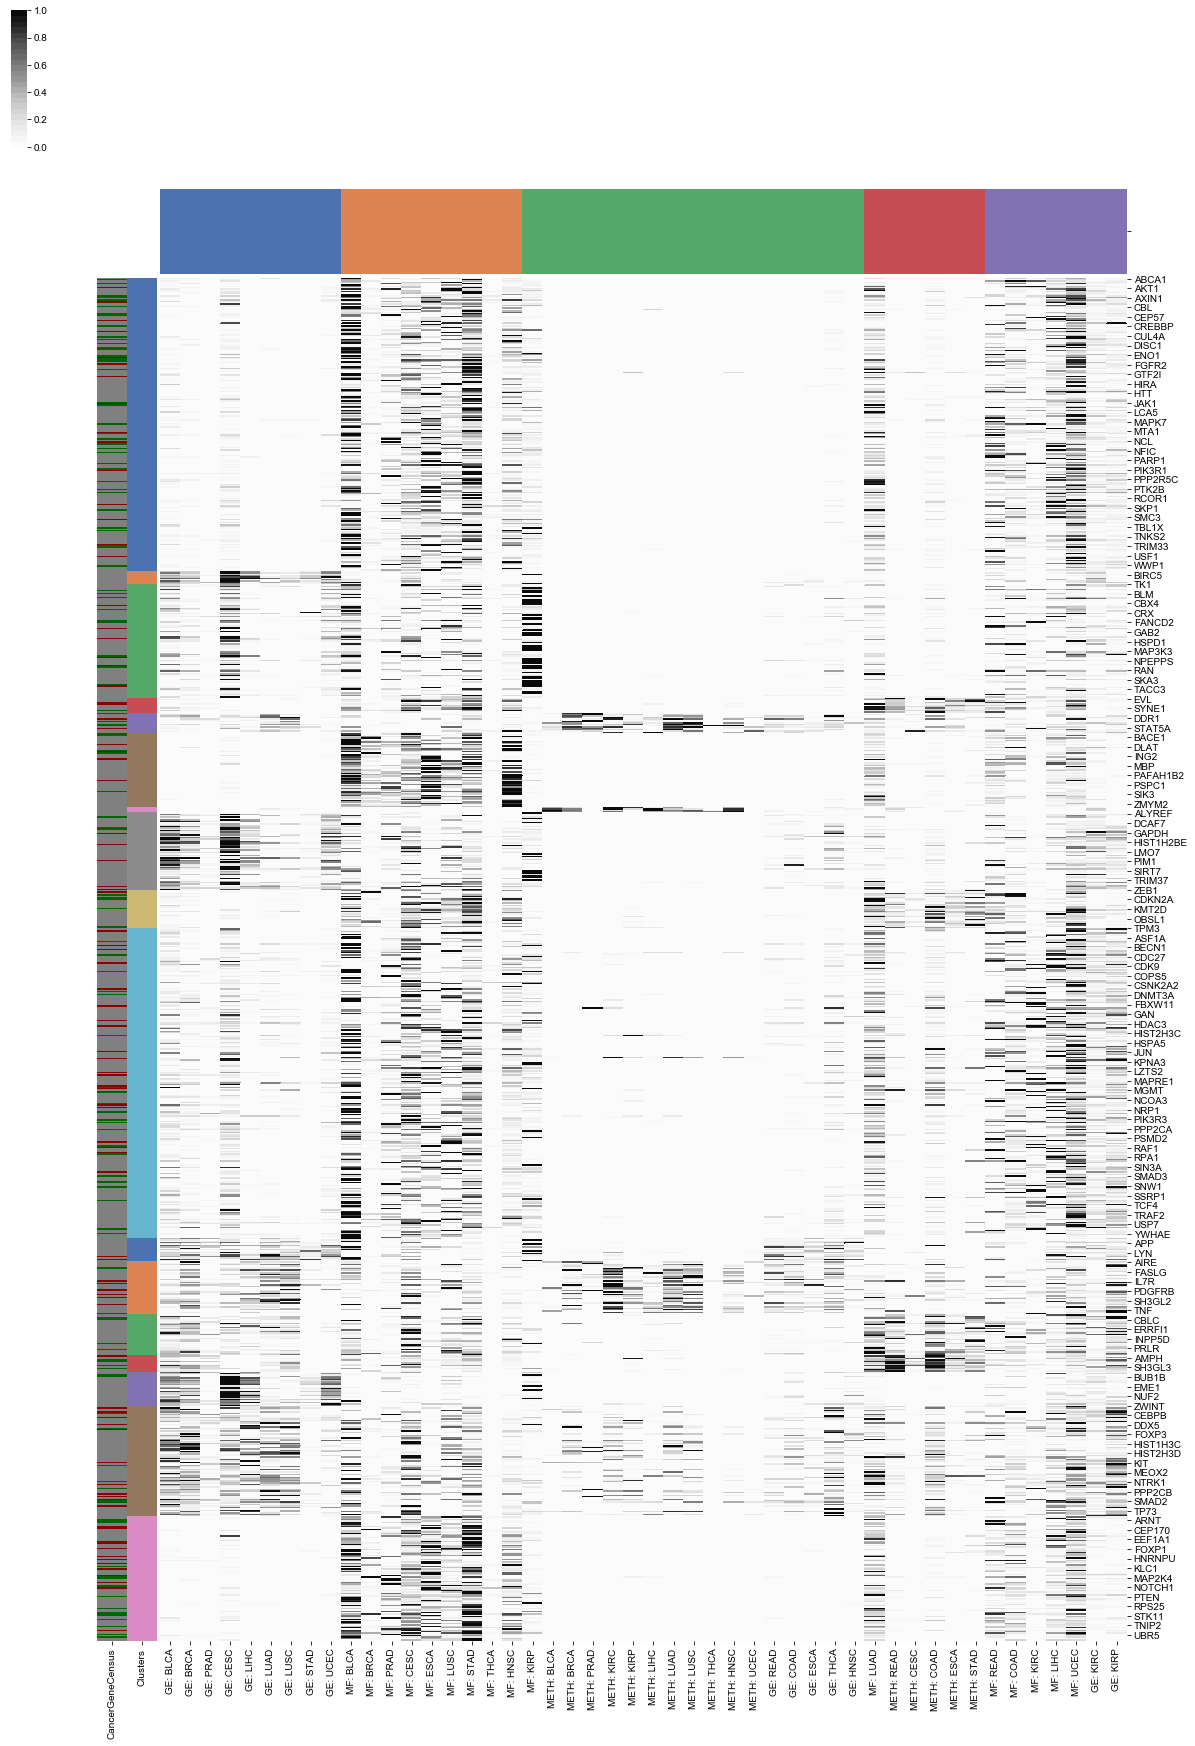

In [9]:
n_clusters = (17, 5)

model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1, random_state=0
                            )
model.fit(high_feat_contrib_normed)
newOrder_row = [list(r) for r in zip(model.row_labels_, high_feat_contrib_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, high_feat_contrib_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = high_feat_contrib_capped.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns
X_plot.head()

lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat_contrib.shape[0])
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat_contrib.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=high_feat_contrib.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='euclidean',
                  #cmap="RdBu_r",
                  cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=high_feat_contrib.columns).map(lut_flatclu),
                  yticklabels=7, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=0, z_score=None, robust=False
                 )
#cm.savefig(os.path.join(model_dir, 'biclustering_lrp_highconf.png'), dpi=300)

In [10]:
# relevant clusters are calculated by row_index * n_columns + col_index
# starting at 0. For instance, the cluster in in the 6th row and 2nd column (brown and orange)
# has number 5 * 5 + 1 = 26
relevant_clusters = [1, 26, 35, 49, 57, 63, 70, 81]

In [11]:
# write the biclusters to disk
count = 1
for cluster_number in relevant_clusters:
    subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    genes.to_csv(os.path.join(model_dir, 'bicluster_{}.tsv'.format(count)), sep='\t')
    count += 1

In [12]:
cluster_pathways_highconf = []
for cluster_number in relevant_clusters:
    subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    top_pathways = get_pathway_enrichment(genes, nodes, cluster_number, model_dir, clean_up=False)
    cluster_pathways_highconf.append((cluster_number, top_pathways))

In [13]:
high_feat = pd.DataFrame(features_raw,
                         index=node_names[:feature_contributions.shape[0], 1],
                         columns=feature_names
                        )
high_feat = high_feat[high_feat.index.isin(high_feat_contrib_normed.index)]
(high_feat.index == high_feat_contrib_normed.index).all()

True

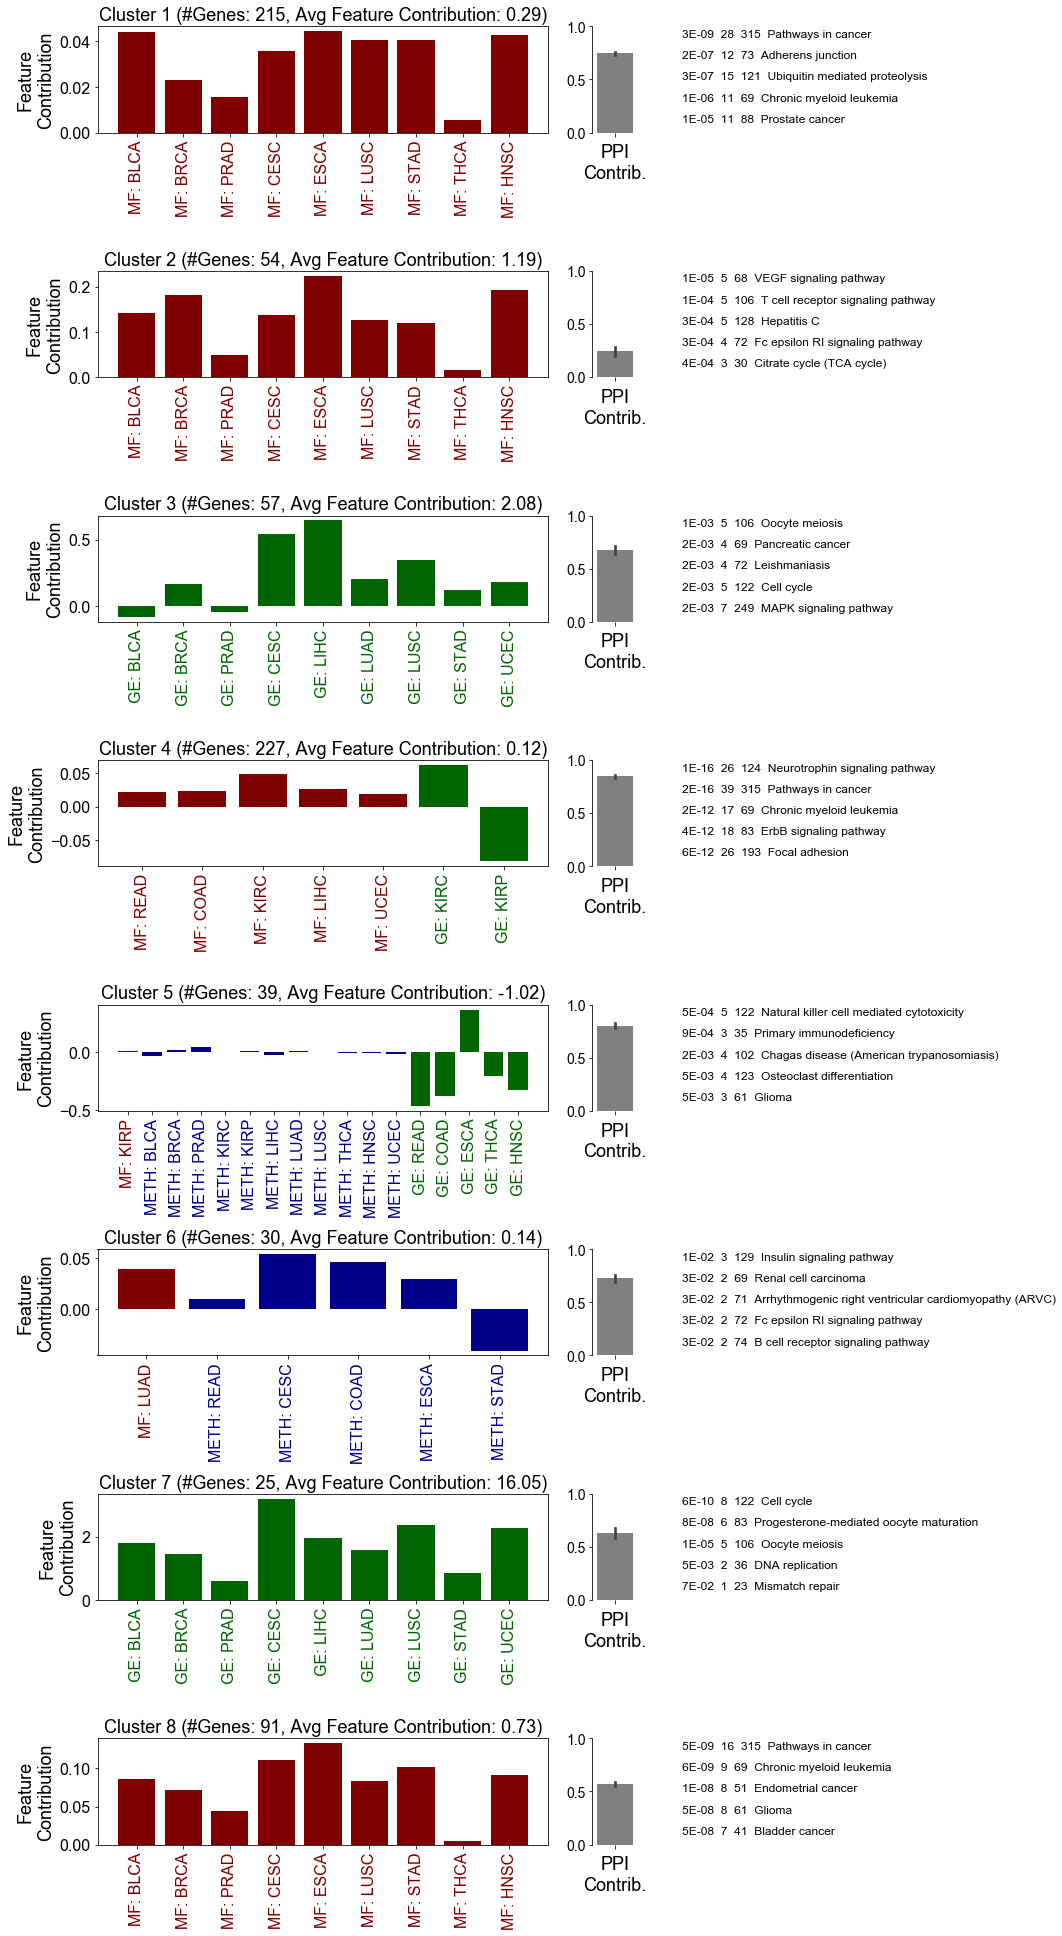

In [15]:
fig, axes = plt.subplots(nrows=len(relevant_clusters), ncols=3,
                         figsize=(15, len(relevant_clusters)*3 + 3),
                         gridspec_kw={'width_ratios': [5, 0.5, 3]}
                        )

plot_count = 0
for cluster_number in relevant_clusters:
    # find the genes in the current cluster
    subcluster = high_feat.iloc[model.get_indices(cluster_number)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    
    # compute the representative for that cluster
    representative = subcluster.mean(axis=0)
    representative_std = subcluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[plot_count][0], representative, None, subcluster.columns.tolist(),
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(plot_count + 1,
                                                                                         genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )

    # get network and feature contributions for the cluster
    all_features_cluster = high_feat_contrib_capped[high_feat_contrib_capped.index.isin(genes.Name)]
    sns.barplot(1-all_features_cluster.sum(axis=1), ax=axes[plot_count][1], orient='v', color='grey')
    axes[plot_count][1].set_ylim([0, 1])
    axes[plot_count][1].set_xlabel('PPI\nContrib.', fontsize=18)
    axes[plot_count][1].spines['right'].set_visible(False)
    axes[plot_count][1].spines['top'].set_visible(False)
    axes[plot_count][1].spines['bottom'].set_visible(False)
    axes[plot_count][1].tick_params(axis='y', labelsize=14)

    # plot the pathways next to it
    plot_pathway_information(axes[plot_count][2], cluster_pathways_highconf[plot_count][1])
    plot_count += 1

plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'bicluster_representatives_highconf.pdf'))

## GO Enrichment for Biclusters

In [16]:
# Get the data
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
  gunzip gene2go.gz
go-basic.obo: fmt(1.2) rel(2020-07-16) 47,259 GO Terms
HMS:0:00:03.938550 338,121 annotations READ: gene2go 
1 taxids stored: 9606
CC 19,414 annotated human genes
MF 18,162 annotated human genes
BP 18,597 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 81% 16,864 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,853 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 83% 17,359 of 20,913 population items found in association


In [17]:
cluster_i = 1
for cluster_number in relevant_clusters:
    # find the genes in the current cluster
    subcluster = high_feat_contrib_capped.iloc[model.get_indices(cluster_number)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    geneids_study = [int(i) for i in list(ut.get_entrez_from_symbol(genes.Name).index) if not i is None]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    #plot_results(os.path.join(out_dir, 'SCC_{}_goenrichment.png'.format(comp+1)), goea_results_sig)
    goeaobj.wr_xlsx(os.path.join(model_dir, 'BiCluster_{}_goenrichment.xlsx'.format(cluster_i)), goea_results_sig)
    cluster_i += 1

querying 1-215...done.
Finished.
5 input query terms found no hit:
	['HIST3H3', 'H3F3A', 'HIST2H2AC', 'H2AFX', 'FGFR1OP']

Run BP Gene Ontology Analysis: current study set of 210 IDs ...
100%    209 of    210 study items found in association
100%    210 of    210 study items found in population(20913)
Calculating 12,274 uncorrected p-values using fisher_scipy_stats
  12,274 GO terms are associated with 16,864 of 20,913 population items
   2,284 GO terms are associated with    209 of    210 study items
  METHOD fdr_bh:
     205 GO terms found significant (< 0.05=alpha) (205 enriched +   0 purified): statsmodels fdr_bh
     194 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 210 IDs ...
100%    210 of    210 study items found in association
100%    210 of    210 study items found in population(20913)
Calculating 1,754 uncorrected p-values using fisher_scipy_st

In [18]:
X_plot.sum(axis=1).rolling(window=30).median().max()

0.7553813247939615

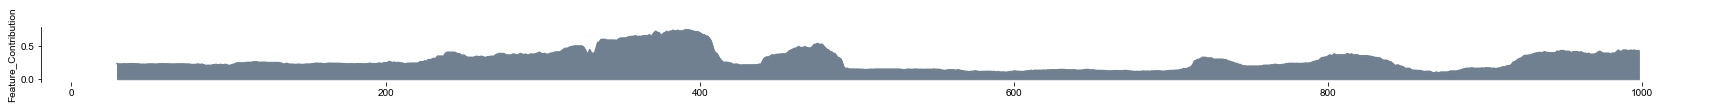

In [19]:
def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg, color='#708090')
    plt.fill_between(range(data.shape[0]), rolling_avg, color='#708090')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    
feat_contrib_cmindex = X_plot.sum(axis=1).rename('Feature_Contribution')
fig = plt.figure(figsize=(30, 1))
ax = plt.subplot(1, 1, 1)
plot_rolling_avg(ax, feat_contrib_cmindex, window_size=30)
#fig.savefig(os.path.join(model_dir, 'biclustering_density_contributions.png'), dpi=300)

Text(0, 0.5, 'Feature Contribution')

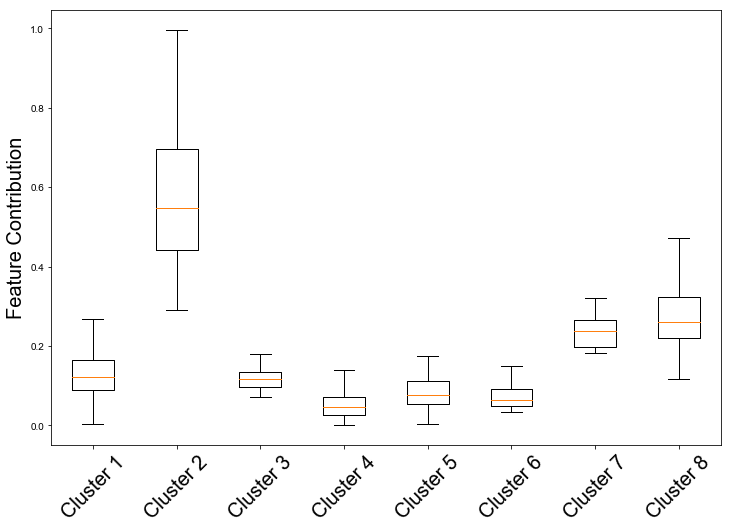

In [14]:
all_feat_contrib_sum = []
for cluster in relevant_clusters:
    submat = model.get_submatrix(cluster, data=high_feat_contrib_capped)
    feat_contrib_cluster = submat.sum(axis=1)
    all_feat_contrib_sum.append(feat_contrib_cluster)

fig = plt.figure(figsize=(12, 8))
_ = plt.boxplot(all_feat_contrib_sum, showfliers=False)
_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
               rotation=45, fontsize=20)
plt.ylabel('Feature Contribution', fontsize=20)

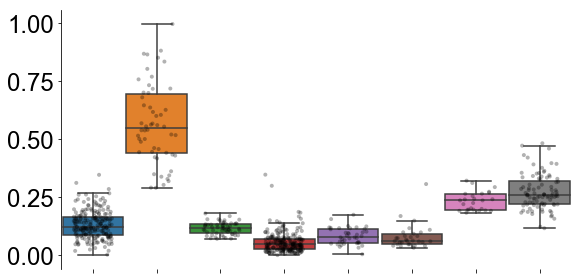

In [40]:
fig = plt.figure(figsize=(8, 4))
df_plot = pd.DataFrame(all_feat_contrib_sum)
df_plot['Cluster'] = df_plot.index.values + 1
sns.boxplot(data=df_plot.melt(id_vars=['Cluster']), x='Cluster', y='value', showfliers=False, width=0.95)
sns.stripplot(data=df_plot.melt(id_vars=['Cluster']), x='Cluster', y='value', alpha=0.3,
              size=4, color='black', jitter=0.3)
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=20)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_stats_feat_contrib.svg'))

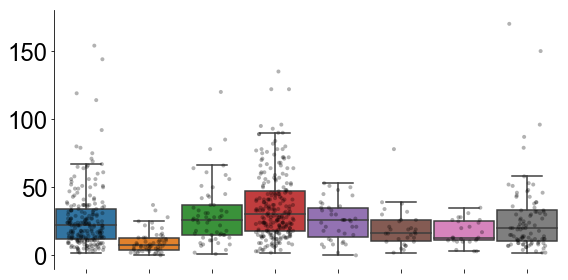

In [41]:
nodes_highconf = pd.DataFrame(high_feat_contrib.index.copy(), columns=['Name']).set_index('Name')
nodes_highconf['Cluster'] = model.row_labels_

nodes_highconf = nodes_highconf[nodes_highconf.Cluster.isin([0, 5, 7, 9, 11, 12, 14, 16])]

# put in the amount of feature contribution
nodes_highconf_pred = nodes_highconf.join(pred.set_index('Name'))
nodes_enriched = nodes_highconf_pred.join(high_feat_contrib.sum(axis=1).rename('Feature_Contribution'))

# put in the labels (known cancer genes)
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

# put in number of cancer neighbors
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
nodes_enriched = nodes_enriched.join(num_known_neighbors)

# put in the number of NPCGs per cluster
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(len(relevant_clusters))]

# next, plot the number of known cancer gene neighbors
fig = plt.figure(figsize=(8, 4))
g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'Num_Cancer_Gene_Neighbors']], id_vars='Cluster'),
            x='Cluster', y='value', showfliers=False, width=.95)
sns.stripplot(data=pd.melt(nodes_enriched[['Cluster', 'Num_Cancer_Gene_Neighbors']], id_vars='Cluster'),
            x='Cluster', y='value', alpha=0.3, size=4, jitter=0.3, color='black')
#g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=28)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_stats_neighbors.svg'))

### Significance of Feature Contributions vs. Network

In [23]:
clust_of_interest = nodes_enriched.Feature_Contribution
for c in nodes_enriched.Cluster.unique():
    genes_in_cluster = nodes_enriched[nodes_enriched.Cluster == c]
    feat_contrib_cluster = genes_in_cluster.Feature_Contribution
    _, pval = scipy.stats.ttest_ind(clust_of_interest, feat_contrib_cluster)
    print ('Cluster {}\tP-value: {}'.format(c, pval))

Cluster 16	P-value: 7.511605351521806e-08
Cluster 5	P-value: 4.9954186456278865e-45
Cluster 0	P-value: 0.000648078327908553
Cluster 9	P-value: 5.962022129864495e-16
Cluster 14	P-value: 0.04994222193565919
Cluster 7	P-value: 0.031026335608291912
Cluster 11	P-value: 0.10053877038096548
Cluster 12	P-value: 0.5848417461355745


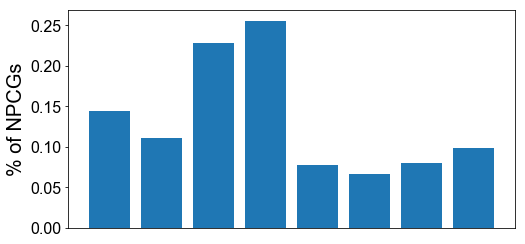

In [24]:
fig = plt.figure(figsize=(8, 4))
npcgs_per_cluster = nodes_enriched[['Cluster', 'NPCG']].groupby('Cluster').NPCG.mean()# / npcgs.shape[0]
plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=npcgs_per_cluster)
plt.ylabel('% of NPCGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
#fig.savefig(os.path.join(model_dir, 'cluster_stats_npcgs.svg'))

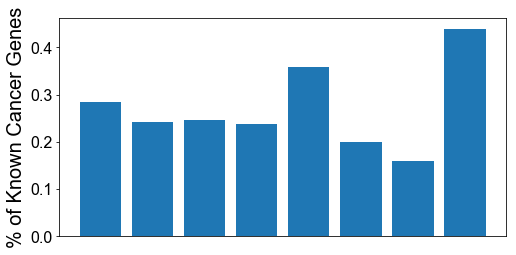

In [25]:
fig = plt.figure(figsize=(8, 4))
npcgs_per_cluster = nodes_enriched[['Cluster', 'label']].groupby('Cluster').label.mean()# / npcgs.shape[0]
plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=npcgs_per_cluster)
plt.ylabel('% of Known Cancer Genes', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
#plt.ylim([0.1, 0.48])
#fig.savefig(os.path.join(model_dir, 'cluster_stats_knowns.svg'))

In [43]:
essential_genes = pd.read_csv(achilles_data_path).T
essential_genes.columns = essential_genes.loc['Unnamed: 0']
essential_genes.drop('Unnamed: 0', inplace=True)
essential_genes['Name'] = [i.split('(')[0].strip() for i in essential_genes.index]
essential_genes.set_index('Name', inplace=True)
# sum and join with nodes
essentiality = (essential_genes < -0.5).sum(axis=1)
nodes_enriched = nodes_enriched.join(essentiality.rename('essentiality'), how='inner')

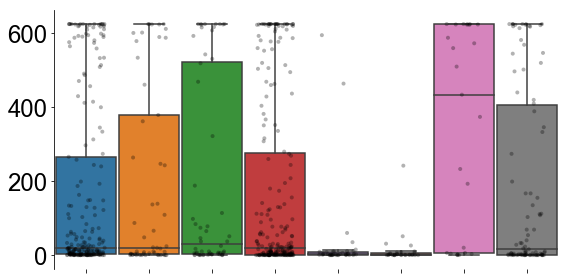

In [44]:
fig = plt.figure(figsize=(8, 4))
g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'essentiality']], id_vars='Cluster'),
            x='Cluster', y='value', showfliers=False, width=0.95)
sns.stripplot(data=pd.melt(nodes_enriched[['Cluster', 'essentiality']], id_vars='Cluster'),
            x='Cluster', y='value', alpha=0.3, size=4, jitter=0.3, color='black')
#g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=28)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_stats_essentiality.svg'))

## Significance for clusters

In [28]:
for c in nodes_enriched.Cluster.unique():
    genes_in_cluster = nodes_enriched[nodes_enriched.Cluster == c]
    npcgs_in_cluster = genes_in_cluster.NPCG.sum()
    non_npcgs_in_cluster = genes_in_cluster.shape[0] - npcgs_in_cluster
    npcgs_non_cluster = nodes_enriched[~nodes_enriched.index.isin(genes_in_cluster)].NPCG.sum()
    nonnpcgs_non_cluster = nodes_enriched.shape[0] - npcgs_non_cluster
    cont = [[npcgs_in_cluster, npcgs_non_cluster], [non_npcgs_in_cluster, nonnpcgs_non_cluster]]

    # do fishers exact test
    odds_ratio, pvalue = scipy.stats.fisher_exact(cont)
    print ("Cluster {}\tP-value: {}".format(c, pvalue))

Cluster 16	P-value: 0.096933523944409
Cluster 5	P-value: 0.3431874060731783
Cluster 0	P-value: 0.46186105131407107
Cluster 9	P-value: 0.004633526345970947
Cluster 14	P-value: 0.4085852460308792
Cluster 7	P-value: 0.26977140352035395
Cluster 11	P-value: 0.18119262471872027
Cluster 12	P-value: 0.2044855642238445


In [29]:
clust_of_interest = nodes_enriched.essentiality
for c in nodes_enriched.Cluster.unique():
    genes_in_cluster = nodes_enriched[nodes_enriched.Cluster == c]
    essentiality_cluster = genes_in_cluster.essentiality
    whate, pval = scipy.stats.ttest_ind(clust_of_interest, essentiality_cluster)
    print ('Cluster {}\tP-value: {}'.format(c, pval))
    print (whate)

Cluster 16	P-value: 0.47474038525045514
-0.7151184776244558
Cluster 5	P-value: 0.4374836322667116
-0.7768490907995655
Cluster 0	P-value: 0.9916861895315455
-0.010422779652689498
Cluster 9	P-value: 0.9686265893296864
0.03934125558860828
Cluster 14	P-value: 0.00024085545176916672
-3.689570388296787
Cluster 7	P-value: 0.3309120953351834
-0.9728833831927678
Cluster 11	P-value: 0.0008314954156266026
3.355431350363878
Cluster 12	P-value: 0.0008892203271928522
3.3367198694320943


In [34]:
nodes_highconf = pd.DataFrame(high_feat_contrib.index.copy(), columns=['Name']).set_index('Name')
nodes_highconf['Cluster'] = model.row_labels_
nodes_highconf = nodes_highconf.join(essentiality.rename('essentiality'), how='left')
nodes_highconf.loc[nodes_highconf.essentiality.isnull(), 'essentiality'] = 0

genes_in_cluster = nodes_highconf[nodes_highconf.Cluster == 14] # cluster 7 in figure 5
essential_in_cluster = (genes_in_cluster.essentiality > essentiality.mean()).sum()
non_essential_in_cluster = (genes_in_cluster.essentiality <= essentiality.mean()).sum()
essential_non_cluster = (nodes_highconf[~nodes_highconf.index.isin(genes_in_cluster)].essentiality > essentiality.mean()).sum()
nonessential_non_cluster = (nodes_highconf[~nodes_highconf.index.isin(genes_in_cluster)].essentiality <= essentiality.mean()).sum()
cont = [[essential_in_cluster, essential_non_cluster], [non_essential_in_cluster, nonessential_non_cluster]]

# do fishers exact test
odds_ratio, pvalue = scipy.stats.fisher_exact(cont)
print ("P-value: {}".format(pvalue))

P-value: 0.002035473580168913


90 96


Text(0.5, 0, '')

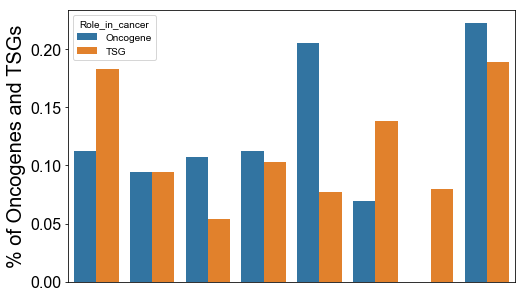

In [35]:
nodes_enriched['Oncogene'] = 0
nodes_enriched['TSG'] = 0
oncogenes = cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index
tsgs = cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index
nodes_enriched.loc[nodes_enriched.index.isin(oncogenes), 'Oncogene'] = 1
nodes_enriched.loc[nodes_enriched.index.isin(tsgs), 'TSG'] = 1
print (nodes_enriched.Oncogene.sum(), nodes_enriched.TSG.sum())

fig = plt.figure(figsize=(8, 5))
oncogenes_per_cluster = pd.DataFrame(nodes_enriched[['Cluster', 'Oncogene']].groupby('Cluster').Oncogene.mean().rename('value'))# / npcgs.shape[0]
tsgs_per_cluster = pd.DataFrame(nodes_enriched[['Cluster', 'TSG']].groupby('Cluster').TSG.mean().rename('value'))# / npcgs.shape[0]
oncogenes_per_cluster['Role_in_cancer'] = 'Oncogene'
tsgs_per_cluster['Role_in_cancer'] = 'TSG'
combined = pd.concat((oncogenes_per_cluster, tsgs_per_cluster))
combined['Cluster'] = combined.index
sns.barplot(data=combined, x='Cluster', y='value', hue='Role_in_cancer')
plt.ylabel('% of Oncogenes and TSGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel(None)

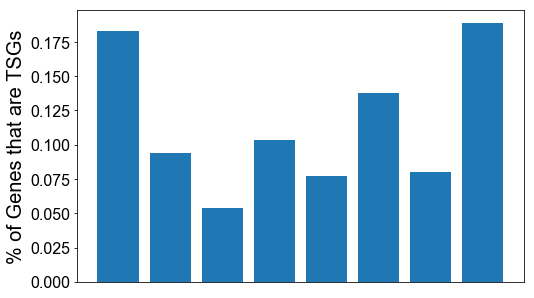

In [36]:
fig = plt.figure(figsize=(8, 5))
tsgs_per_cluster = nodes_enriched[['Cluster', 'TSG']].groupby('Cluster').TSG.mean()# / npcgs.shape[0]
plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=tsgs_per_cluster)
plt.ylabel('% of Genes that are TSGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
#fig.savefig(os.path.join(model_dir, 'cluster_stats_knowns.svg'))

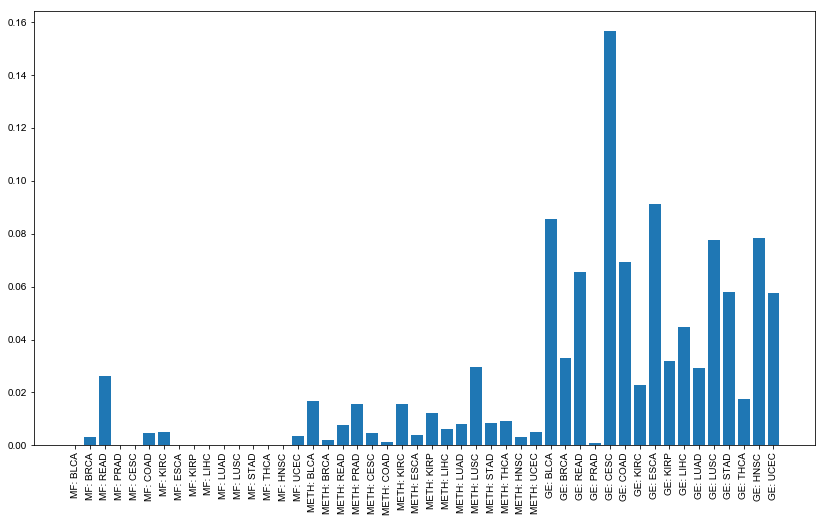

In [37]:
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=features_df[features_df.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(features_df.shape[1])), labels=features_df.columns, rotation=90)

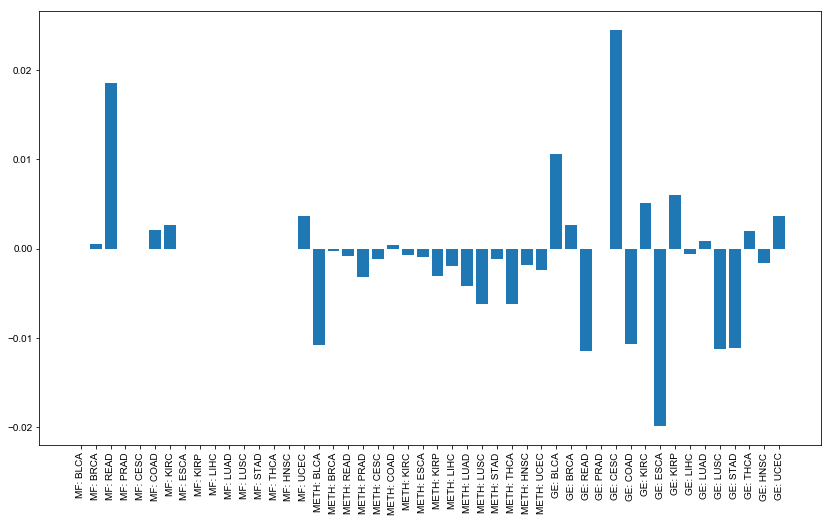

In [38]:
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=high_feat_contrib[high_feat_contrib.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(high_feat_contrib.shape[1])), labels=high_feat_contrib.columns, rotation=90)

In [39]:
high_feat_contrib.iloc[:, 16:32].mean(axis=1).sort_values(ascending=False).head()

REG3A    0.044
REG1B    0.038
HAVCR1   0.034
LILRB2   0.030
TLX3     0.021
dtype: float64

## Sanity Check: What do Silhouette Scores Say About the Optimal Number of Clusters

In [41]:
scores = []
combinations = []
for num_row_clusters in range(10, 20):
    for num_col_clusters in range(3, 10):
        #print (num_row_clusters, num_col_clusters)
        model = SpectralBiclustering(n_clusters=(num_row_clusters, num_col_clusters), method='bistochastic',
                                     svd_method='randomized', n_jobs=-1#, random_state=0
                                    )
        model.fit(high_feat_contrib_normed)
        score = metrics.silhouette_score(high_feat_contrib_normed, model.row_labels_ ,metric='euclidean')
        combinations.append((num_row_clusters, num_col_clusters))
        scores.append(score)

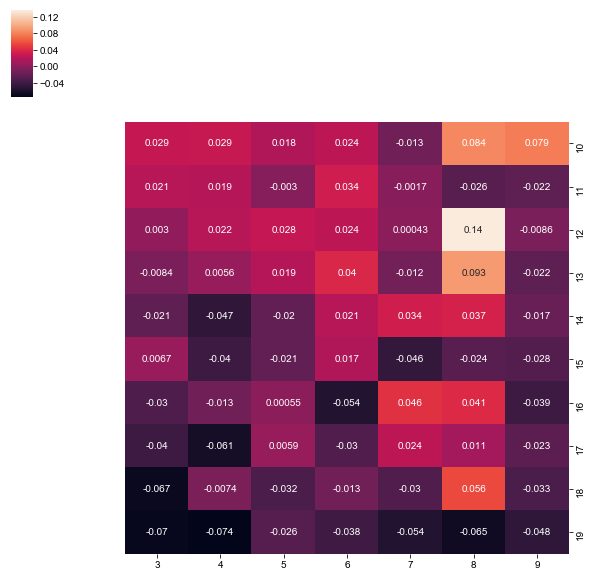

In [42]:
x = np.zeros((pd.Series(([i[0] for i in combinations])).nunique(),
              pd.Series(([i[1] for i in combinations])).nunique())
            )
x = pd.DataFrame(x, index=range(10, 20), columns=range(3, 10))
for i in range(len(combinations)):
    x.loc[combinations[i][0], combinations[i][1]] = scores[i]
sns.clustermap(x, method=None, row_cluster=False, col_cluster=False, annot=True)

## Sanity Check: Biclustering of the *Input Features*
This is a sanity check to see what comes out when looking at only the input data.

Selected 1000 Genes for Spectral Biclustering


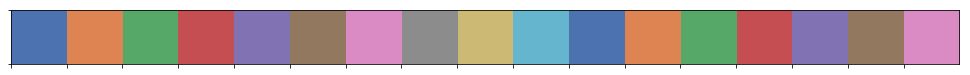

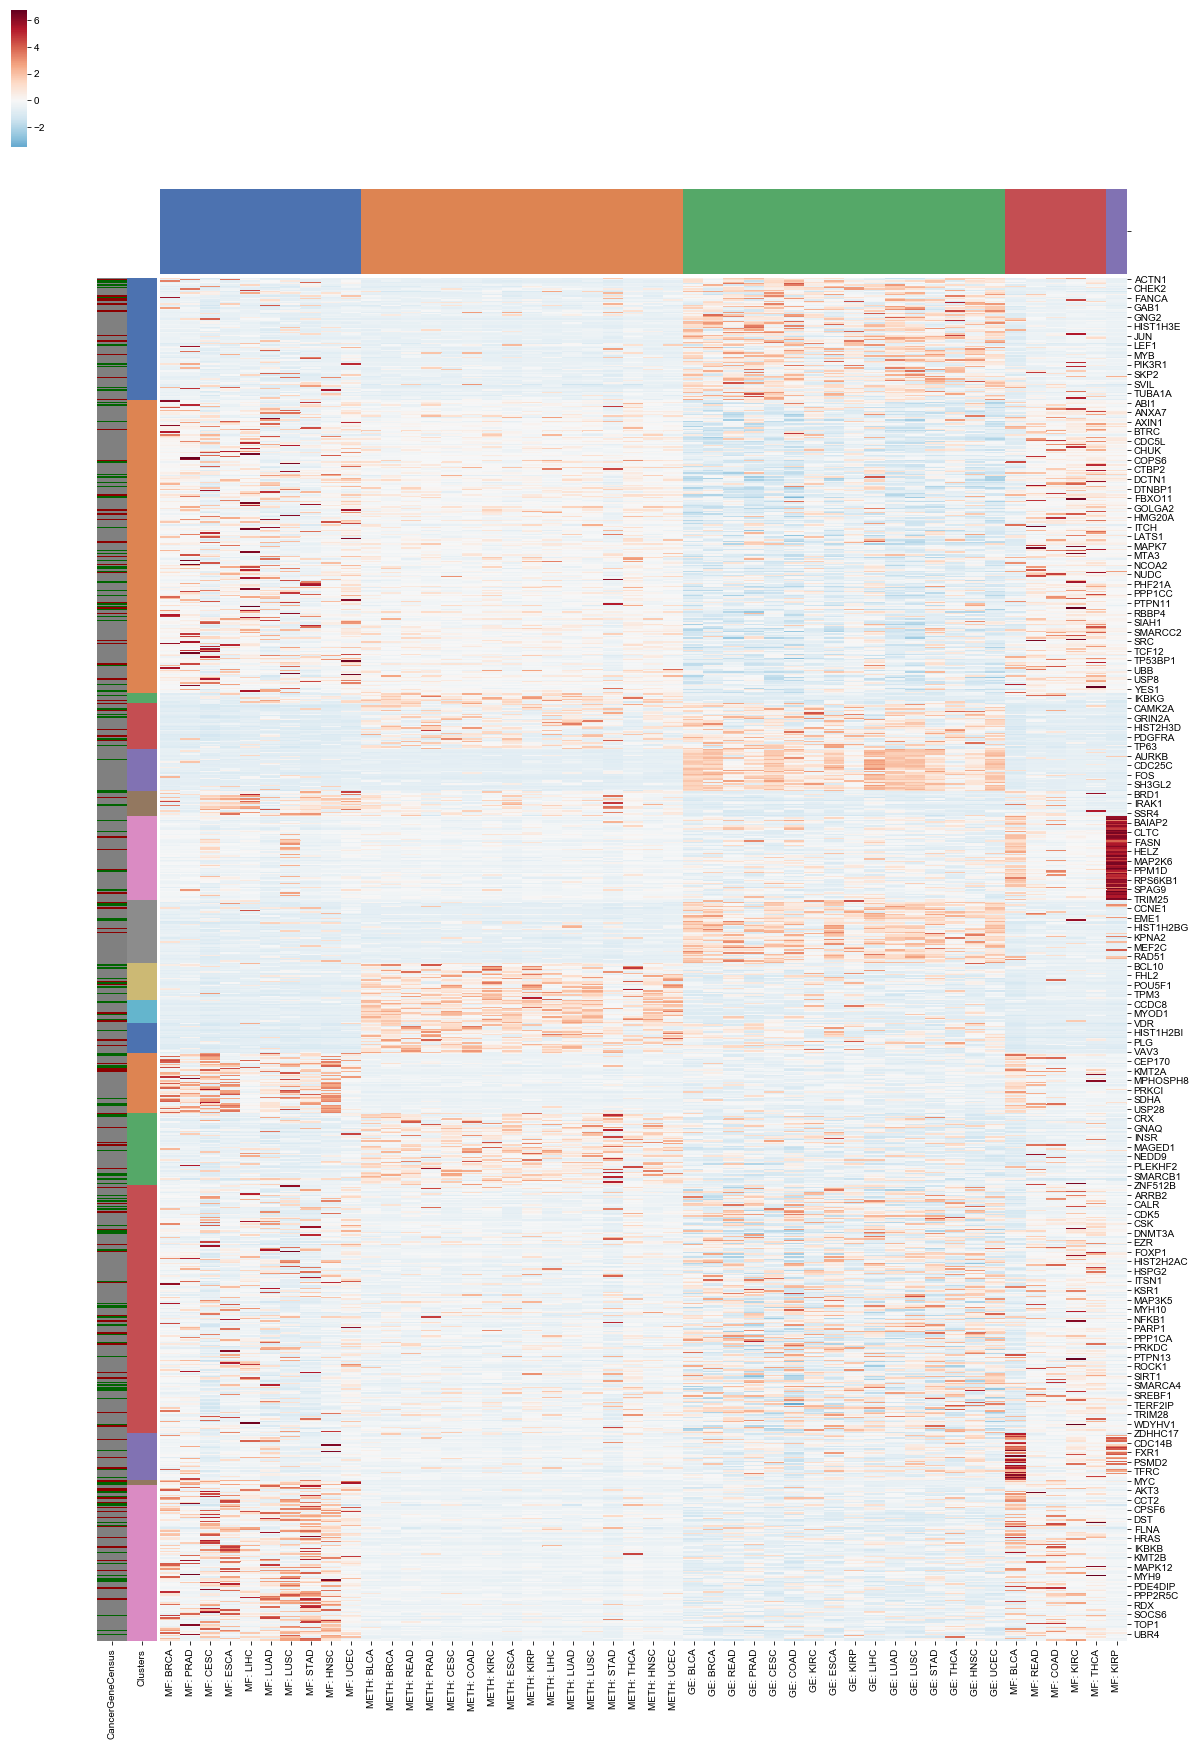

In [43]:
# select only top 1000 predictions
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
features_top1000 = features_df[features_df.index.isin(pred.head(1000).Name)]
print ("Selected {} Genes for Spectral Biclustering".format(features_top1000.shape[0]))

# do the spectral biclustering
n_clusters = (17, 5)
features_top1000_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(features_top1000),
                                        index=features_top1000.index, columns=features_top1000.columns)
model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1, random_state=0
                            )
model.fit(features_top1000_normed)

# get new row and column orders
newOrder_row = [list(r) for r in zip(model.row_labels_, features_top1000_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, features_top1000_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = features_top1000_normed.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns

# get the clusters as colormaps to show on the side
lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get some information on known cancer genes (oncogenes vs TSGs vs unknown)
cgc = pd.read_csv(cgc_path).set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(features_top1000_normed.shape[0])
onco_tsg_annotation[features_top1000_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[features_top1000_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=features_top1000_normed.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=features_top1000_normed.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='correlation',
                  cmap="RdBu_r",
                  #cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=features_top1000_normed.columns).map(lut_flatclu),
                  yticklabels=7, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=None, z_score=False, robust=False, center=0
                 )
cm.savefig(os.path.join(model_dir, 'biclustering_input_top1000.png'), dpi=300)

## Sanity Check: Biclustering of Contributions *of All Genes*

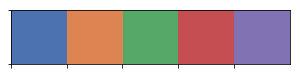

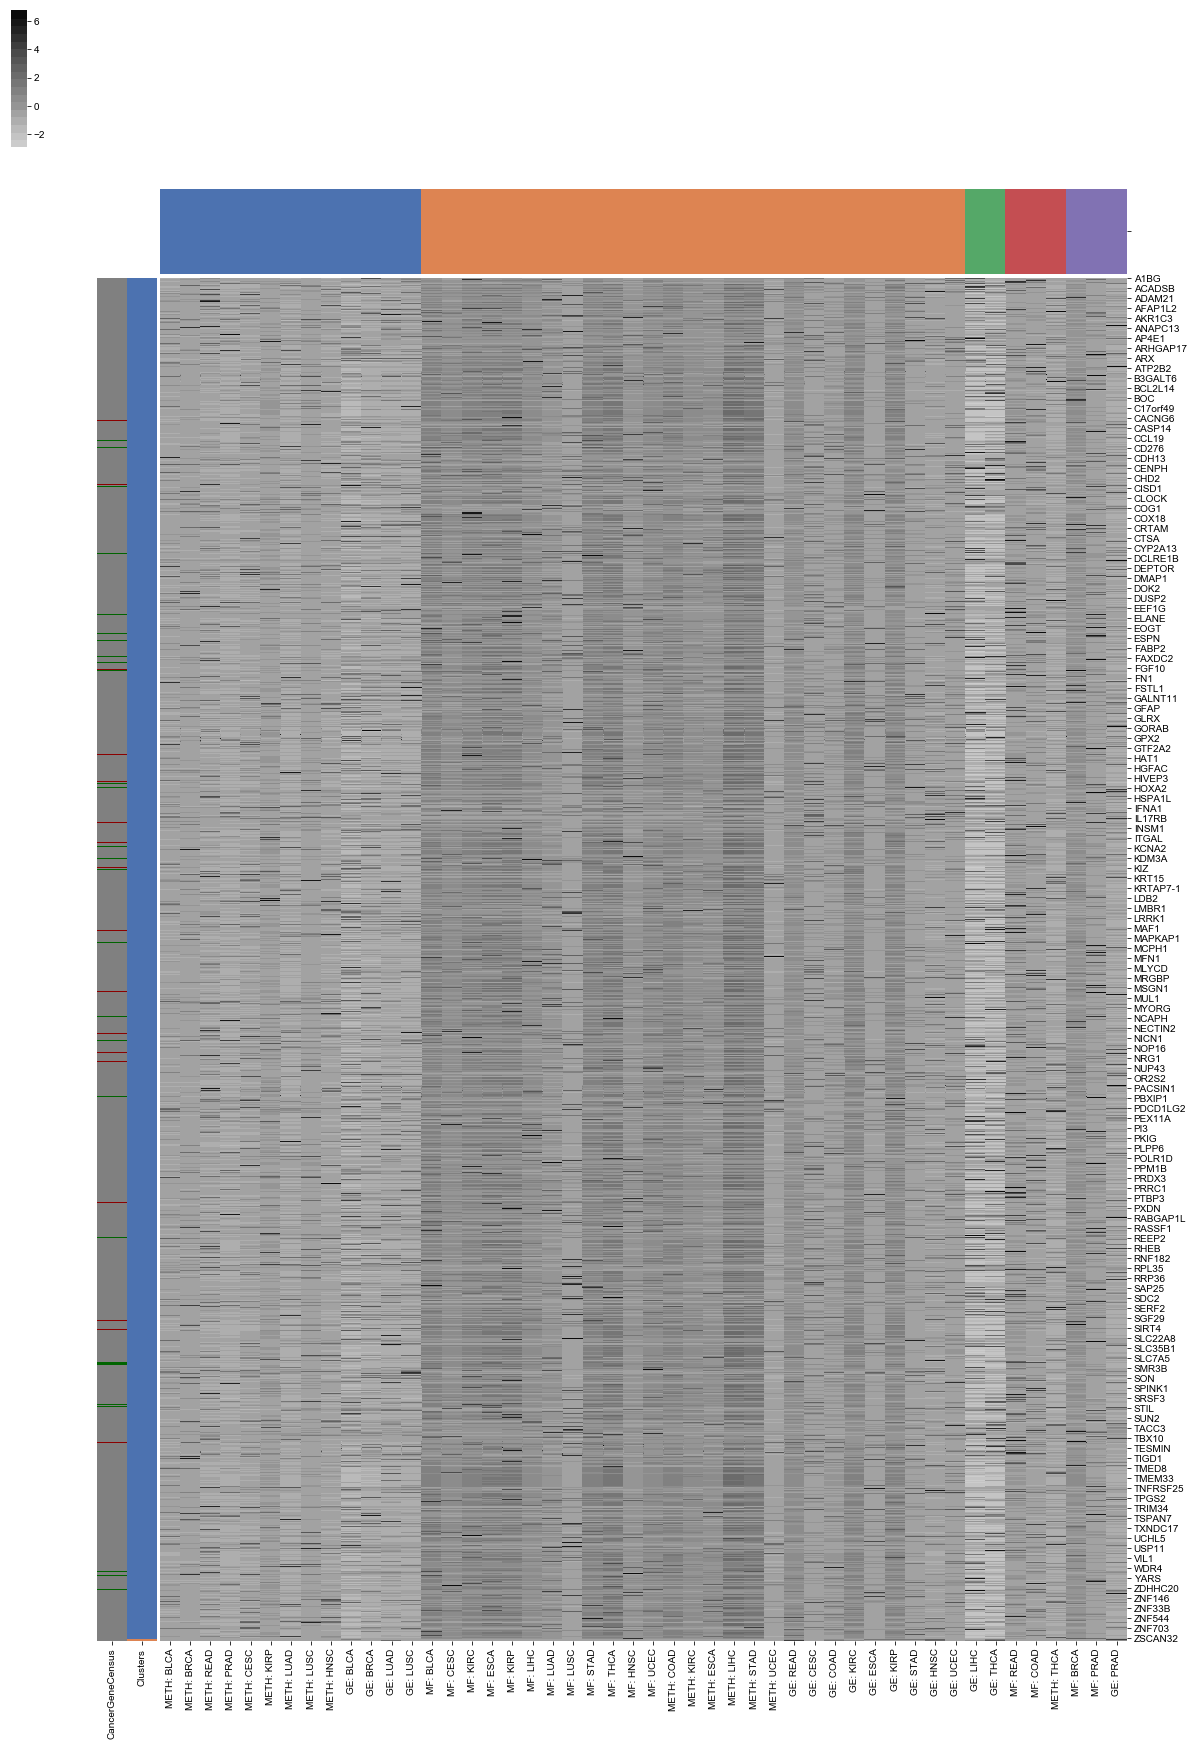

In [44]:
# remove negative contributions
feat_contrib_capped = feat_contrib_df.copy()
feat_contrib_capped[feat_contrib_capped < 0] = 0

# do the spectral biclustering
n_clusters = (2, 5)
feat_contrib_df_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(feat_contrib_capped),
                                      index=feat_contrib_capped.index, columns=feat_contrib_capped.columns)
model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1, random_state=0
                            )
model.fit(feat_contrib_df_normed)

# get new row and column orders
newOrder_row = [list(r) for r in zip(model.row_labels_, feat_contrib_df_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, feat_contrib_df_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = feat_contrib_df_normed.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns

# get the clusters as colormaps to show on the side
lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get some information on known cancer genes (oncogenes vs TSGs vs unknown)
cgc = pd.read_csv(cgc_path).set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(feat_contrib_df_normed.shape[0])
onco_tsg_annotation[feat_contrib_df_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[feat_contrib_df_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=feat_contrib_df_normed.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=feat_contrib_df_normed.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='euclidean',
                  #cmap="RdBu_r",
                  cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=feat_contrib_df_normed.columns).map(lut_flatclu),
                  yticklabels=100, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=None, z_score=False, robust=False, center=0
                 )
cm.savefig(os.path.join(model_dir, 'biclustering_all_genes.png'), dpi=300)

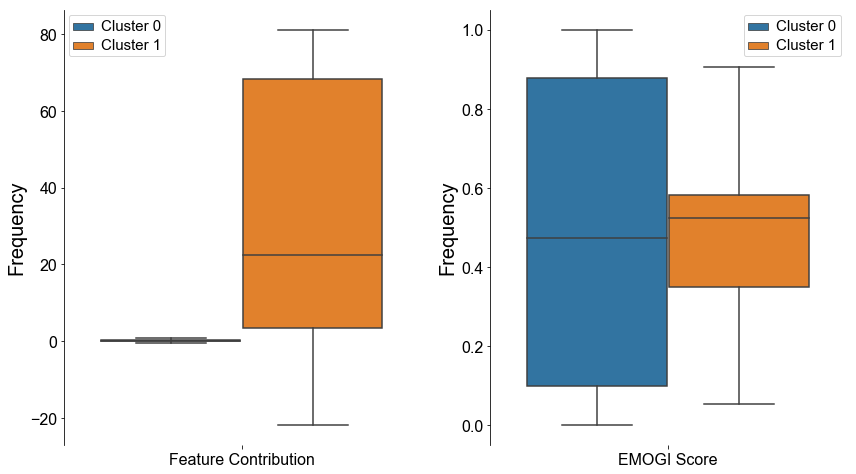

In [45]:
feature_contribs_sum = X_plot.sum(axis=1).rename('Feature_Sum')

n_clusters_boxplots = 2
nodes_with_cluster = nodes.copy()
nodes_cluster_pred = nodes_with_cluster.join(pred.drop('Name', axis=1), on='ID').set_index('Name')
nodes_enriched = nodes_cluster_pred.join(feat_contrib_df.sum(axis=1).rename('Feature_Contribution'))
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0
nodes_enriched.reindex(X_plot.index)
nodes_enriched['Cluster'] = model.row_labels_
cluster_label_list = ['Cluster {}'.format(i) for i in range(n_clusters_boxplots)]

fig = plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
g = sns.boxplot(data=pd.melt(nodes_enriched[['Feature_Contribution', 'Cluster', 'ID']], id_vars=['ID', 'Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=20)
for t, l in zip(g.legend().texts, cluster_label_list):
    t.set_text(l)
    t.set_size(15)
plt.gca().set_xticklabels(['Feature Contribution'])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)

plt.subplot(1, 2, 2)
g = sns.boxplot(data=pd.melt(nodes_enriched[['Prob_pos', 'Cluster', 'ID']], id_vars=['ID', 'Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=20)
for t, l in zip(g.legend().texts, cluster_label_list):
    t.set_text(l)
    t.set_size(15)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(['EMOGI Score'])
fig.savefig(os.path.join(model_dir, 'biclustering_{}_clusters_difference_allgenes.svg'.format(n_clusters_boxplots)))

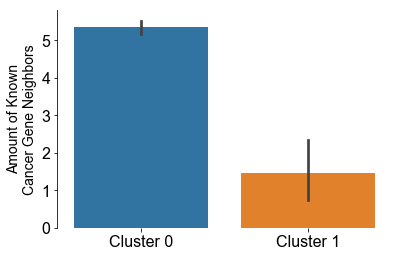

In [46]:
fig = plt.figure(figsize=(6, 4))
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
sns.barplot(data=nodes_enriched.join(num_known_neighbors)[['Cluster', 'Num_Cancer_Gene_Neighbors']], x='Cluster', y='Num_Cancer_Gene_Neighbors')
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Amount of Known\nCancer Gene Neighbors', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#fig.savefig(os.path.join(model_dir, 'biclustering_{}_clusters_cancerneighbors_allgenes.svg'.format(n_clusters_boxplots)))

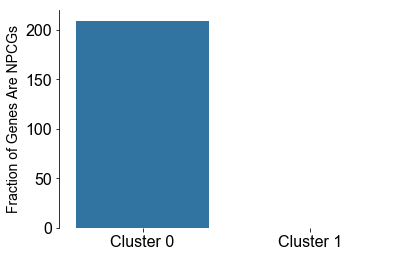

In [47]:
fig = plt.figure(figsize=(6, 4))
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(n_clusters_boxplots)]
sns.barplot(x=cluster_label_list, y=npcgs_cl)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes Are NPCGs', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#fig.savefig(os.path.join(model_dir, '{}_clusters_npcgs_allgenes.svg'.format(n_clusters_boxplots)))

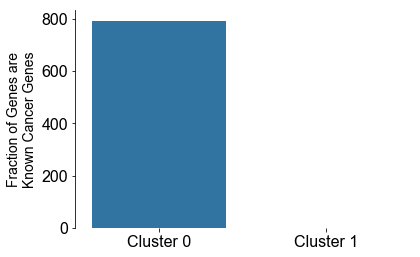

In [48]:
fig = plt.figure(figsize=(6, 4))
cgs = [nodes_enriched[nodes_enriched.Cluster == i].label.sum() for i in range(n_clusters_boxplots)]
#sns.barplot(data=nodes_enriched[['Cluster', 'label']], x='Cluster', y='label')
sns.barplot(x=cluster_label_list, y=cgs)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes are\nKnown Cancer Genes', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#fig.savefig(os.path.join(model_dir, '{}_clusters_literature_allgenes.svg'.format(n_clusters_boxplots)))

## Plot All Features for Row-Clusters
This is just to see the complete picture of the genes in each cluster.

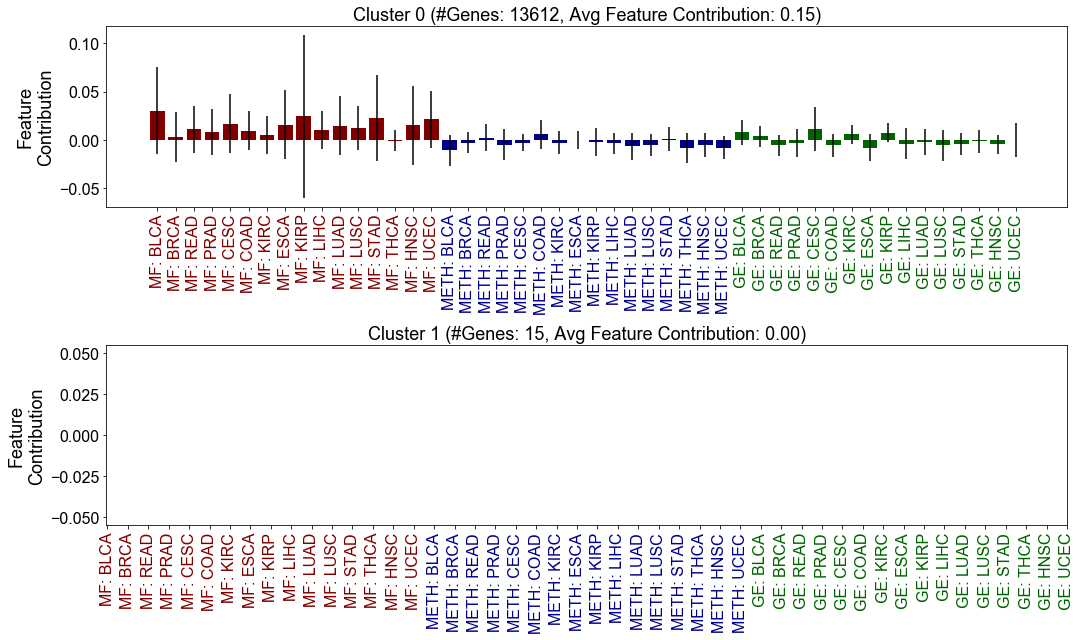

In [69]:
sum_of_all = 0
n_clusters = nodes_enriched.Cluster.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=1,
                         figsize=(15, n_clusters*3 + 3)
                         #gridspec_kw={'width_ratios': [3, 1]}
                        )
def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


for cluster_number in nodes_enriched.Cluster.unique():
    # find the genes in the current cluster
    cluster_genes = nodes_enriched[nodes_enriched.Cluster == cluster_number].index
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib[high_feat_contrib.index.isin(cluster_genes)]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number], representative, representative_std, representative.index,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         cluster_genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

## Are Newly Predicted Cancer Genes Interaction or Feature Driven?

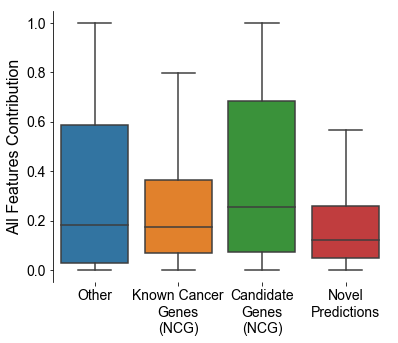

In [72]:
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
oncokb, known, candidate = get_cancer_genes()
npcgs.set_index('Name', inplace=True)
contribution_sum_df = pd.DataFrame(feat_contrib_df.sum(axis=1), columns=['Feature_Sum'])
contribution_sum_df['Gene_Set'] = 'Other'
#contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nCancer Gene'
#contribution_sum_df.loc[contribution_sum_df.index.isin(oncokb['Hugo Symbol']), 'Gene_Set'] = 'OncoKB'
contribution_sum_df.loc[contribution_sum_df.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'
contribution_sum_df.Gene_Set.value_counts()
contribution_sum_df.Feature_Sum = contribution_sum_df.Feature_Sum.abs()
contribution_sum_df.loc[contribution_sum_df.Feature_Sum > 1, 'Feature_Sum'] = 1

fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=contribution_sum_df, x='Gene_Set', y='Feature_Sum', showfliers=False, 
            order=['Other', 'Known Cancer\nGenes\n(NCG)', 'Candidate\nGenes\n(NCG)', 'Novel\nPredictions'])
plt.ylabel('All Features Contribution', fontsize=16)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(model_dir, 'feature_contribution_npcgs.svg'))

In [73]:
contrib_df_copy = feat_contrib_df.copy()
contrib_df_copy[contrib_df_copy < 0] = 0
contrib_df_copy.loc['Omics_Type', :] = [i[0] for i in feat_contrib_df.columns.str.split(':')]
omics_contributions = contrib_df_copy.T.groupby('Omics_Type').sum(axis=1).T

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def minmax(x):
    return x / x.sum(axis=0)
omics_contributions_probs = omics_contributions.apply(minmax, axis=1)

In [74]:
omics_contributions_probs['Gene_Set'] = 'Other'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(high_feat_contrib.index), 'Gene_Set'] = 'Top 1000\nPredictions'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'

In [75]:
omics_contributions_probs.Gene_Set.value_counts()

Other                         11068
Candidate\nGenes\n(NCG)        1094
Top 1000\nPredictions           851
Known Cancer\nGenes\n(NCG)      405
Novel\nPredictions              209
Name: Gene_Set, dtype: int64

In [76]:
assert ((omics_contributions_probs.index == contribution_sum_df.index).all())
omics_contributions_highconf = omics_contributions_probs[contribution_sum_df.Feature_Sum > 0.25]
omics_contributions_highconf.shape

(5932, 4)

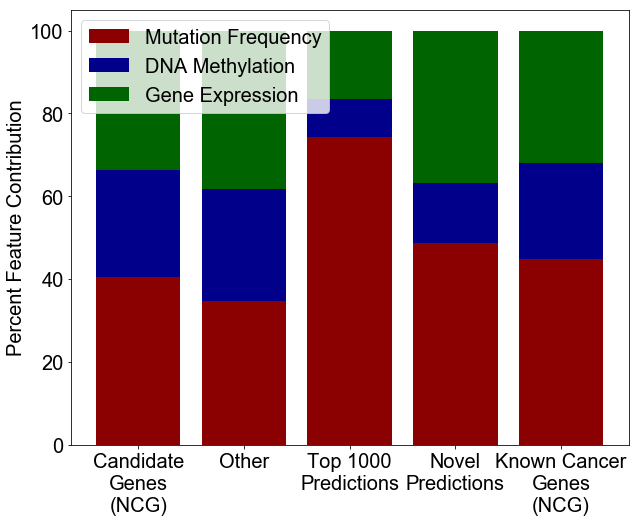

In [77]:
stacked_barplot_vals = {}
gene_sets = omics_contributions_highconf.Gene_Set.unique()
groups = list(range(len(gene_sets)))
for omics in ['MF', 'METH', 'GE']:
    omics_vals = []
    for gene_set in gene_sets:
        omics_vals.append(omics_contributions_highconf.loc[omics_contributions_highconf.Gene_Set == gene_set, omics].mean())
    stacked_barplot_vals[omics] = omics_vals

df = pd.DataFrame(stacked_barplot_vals)
totals = [i+j+k for i,j,k in zip(df['MF'], df['METH'], df['GE'])]
mutation_bars = [i / j * 100 for i,j in zip(df['MF'], totals)]
methylation_bars = [i / j * 100 for i,j in zip(df['METH'], totals)]
expression_bars = [i / j * 100 for i,j in zip(df['GE'], totals)]

fig = plt.figure(figsize=(10, 8))
plt.bar(groups, mutation_bars, color='darkred', label='Mutation Frequency')
plt.bar(groups, methylation_bars, bottom=mutation_bars, color='darkblue', label='DNA Methylation')
plt.bar(groups, expression_bars, bottom=[i+j for i,j in zip(mutation_bars, methylation_bars)],
        color='darkgreen', label='Gene Expression')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.ylabel('Percent Feature Contribution', fontsize=20)
_ = plt.xticks(groups, gene_sets, fontsize=15)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
#fig.savefig(os.path.join(model_dir, 'omics_contributions_genesets.svg'))

In [78]:
stacked_barplot_vals

{'MF': [0.40608068735299285,
  0.3479197656573625,
  0.7421694769691465,
  0.48716646109299877,
  0.4493557277540861],
 'METH': [0.25657453734573515,
  0.270280896205079,
  0.09190554683866622,
  0.14415456257099998,
  0.23028581818081892],
 'GE': [0.3373447753012717,
  0.38179933813755923,
  0.16592497619218716,
  0.3686789763360012,
  0.3203584540650953]}

## Compute Omics Contributions for Top 1000 Genes with Important Interaction Partners

In [79]:
lrp_neighbor_matrix = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix = lrp_neighbor_matrix / float(count)

lrp_neighbor_matrix[lrp_neighbor_matrix < 0] = 0

lrp_neighbors = pd.DataFrame(lrp_neighbor_matrix, index=node_names[:, 1], columns=node_names[:, 1])

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


In [82]:
# make the omics contributions nice and add the network contribution to it
omics_contributions_highconf = omics_contributions_probs.loc[omics_contributions_probs.index.isin(high_feat_contrib.index), :]
omics_contributions_highconf.drop('Gene_Set', inplace=True, axis=1)
omics_contributions_highconf.columns = ['Gene Expression', 'DNA Methylation at Promoters', 'Mutation Frequencies']
omics_contributions_with_network_contrib = omics_contributions_highconf.join(pd.Series(1 - high_feat_contrib.sum(axis=1),
                                                                                       name='Network Contribution')
                                                                            )

# compute the top 5 neighbors for all the genes and add to the data frame
top_ip_all = []
for name, row in omics_contributions_highconf.iterrows():
    ip_contribs = lrp_neighbors[lrp_neighbors.index == name].T
    ip_contribs.drop(name, inplace=True)
    ip_contribs.columns = ['Contributions']
    top_neighbors = ip_contribs.sort_values(by='Contributions', ascending=False).head(5)
    top_ip_all.append(top_neighbors.index.tolist())
most_important_neighbors = pd.DataFrame(top_ip_all, index=omics_contributions_highconf.index,
                                        columns=['Interaction Partner {}'.format(i+1) for i in range(5)]
                                       )
omics_contributions_top_1000 = omics_contributions_with_network_contrib.join(most_important_neighbors)

# write to file
omics_contributions_top_1000.to_csv(os.path.join(model_dir, 'omics_contributions_top1000.tsv'), sep='\t')
omics_contributions_top_1000.head()

/home/sasse/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Gene Expression,DNA Methylation at Promoters,Mutation Frequencies,Network Contribution,Interaction Partner 1,Interaction Partner 2,Interaction Partner 3,Interaction Partner 4,Interaction Partner 5
GRB2,0.438615,0.006082,0.555304,0.773761,C6,TPX2,DLGAP2,ARHGAP12,FGFR3
GAB1,0.501232,0.101364,0.397404,0.985781,TNS1,MAPK4,BMX,PIK3CA,HSH2D
EGFR,0.030200,0.019371,0.950429,0.886523,EYS,PCDHGA3,GRIK4,SLC5A1,PID1
PIK3CA,0.001957,0.002732,0.995311,0.354906,FBP2,KRAS,TMOD1,ADAP1,RPS6KB1
PIK3R1,0.020193,0.000791,0.979016,0.904461,TIE1,DLGAP2,SLC6A2,TPX2,DUSP15
